In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_all_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import joblib

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Prepare

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
print(f'{len(covs)} covariates')

# data
all = pd.read_parquet(f'{folder_path}/data/003_data_overlaid.organized.pq')

# set up
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

all[tgt] = np.log1p(all[prop])

67 covariates


# Initialize Isolation tree

In [3]:
isof = IsolationForest(random_state=42) 

n_splits = 5 
random_state = 42

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize columns to store results
all['iso_class'] = np.nan
all['iso_score'] = np.nan
all['ocd_pred'] = np.nan
all['ocd_pred_log1p'] = np.nan

# Cross-validation
for train_index, val_index in kf.split(all):
    train_fold = all.iloc[train_index]
    val_fold = all.iloc[val_index]
    
    # Train IsolationForest on train fold
    isof = IsolationForest(random_state=random_state)
    isof.fit(train_fold[covs])
    model.fit(train_fold[covs],train_fold[tgt])
    
    # Predict and score on the validation fold
    iso_class = isof.predict(val_fold[covs])
    iso_score = isof.decision_function(val_fold[covs])
    pred = model.predict(val_fold[covs])
    
    # Assign values back to the validation fold in the original DataFrame
    all.loc[val_fold.index, 'iso_class'] = iso_class
    all.loc[val_fold.index, 'iso_score'] = iso_score
    all.loc[val_fold.index, 'ocd_pred'] = np.expm1(pred)
    all.loc[val_fold.index, 'ocd_pred_log'] = pred

In [14]:
all.loc[all['iso_class']==-1, 'prob'].min()

0.6370273195601127

# transform iso scores to probability

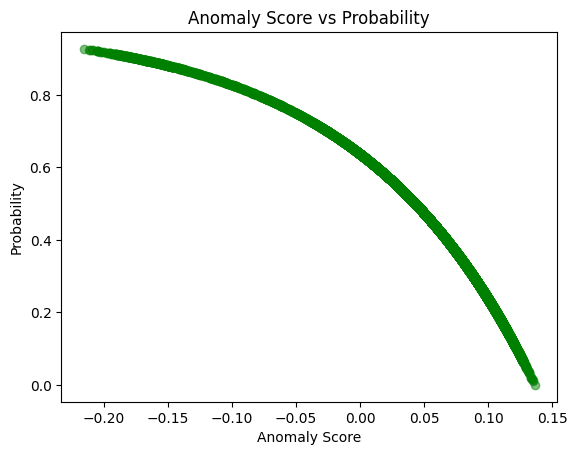

In [4]:
# Invert scores to match R's convention (higher = more anomalous)
iso_score_reverted = -1 * all['iso_score']

# Scale scores to [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(iso_score_reverted.values.reshape(-1, 1)).flatten()

# Calculate probabilities
average_decision_score = np.mean(scaled_scores)
prob = 1 - np.exp(-scaled_scores / (average_decision_score * 2))

# Assign probabilities back to the DataFrame
all['prob'] = prob

# Plot the anomaly scores vs probabilities
plt.scatter(all['iso_score'], prob, alpha=0.5, color="green")
plt.title("Anomaly Score vs Probability")
plt.xlabel("Anomaly Score")
plt.ylabel("Probability")
plt.show()

In [5]:
all['ae'] = all['ocd_pred'] - all['ocd']
epsilon = 0.1 #1e-2
adjusted_ocd = all['ocd'].replace(0, epsilon)
all['mape'] = abs(all['ocd_pred'] - all['ocd']) / adjusted_ocd

In [8]:
bins = [0, 20, 50, 100, 200]
labels = ['0-20', '20-50', '50-100', '100-200']
all['hzn_dep_bin'] = pd.cut(all['hzn_dep'], bins=bins, labels=labels, right=False)

grouped_stats = all.groupby(['lc_survey', 'hzn_dep_bin'])['mape'].describe()
grouped_stats

count      mean        std       min  \
lc_survey                hzn_dep_bin                                           
artificial land          0-20            25.0  0.560923   1.119453  0.038003   
bare land & lichens/moss 0-20           933.0  2.580556  10.522445  0.000000   
cropland                 0-20         13031.0  0.707122   6.033297  0.000022   
                         20-50         5017.0  0.500845   1.176157  0.000253   
                         50-100        4710.0  0.798819   1.668918  0.000284   
                         100-200        111.0  0.884806   1.489115  0.006288   
grassland                0-20          8316.0  0.678252   2.114130  0.000056   
                         20-50         1905.0  1.004897   7.537990  0.000756   
                         50-100        1660.0  0.997895   3.081703  0.000052   
                         100-200        135.0  2.250776  14.439408  0.002222   
shrubland                0-20           187.0  0.463755   0.427469  0.001343   
water areas & wetland    0-20             7.0  1.395073   2.022801  0.046265   
woodland                 0-20          9017.0  0.837709   2.588789  0.000083   
                         20-50          357.0  1.727493   4.706992  0.001710   
                         50-100          59.0  4.478022   4.859654  0.083010   

                                           25%       50%       75%         max  
lc_survey                hzn_dep_bin                                            
artificial land          0-20         0.145222  0.302017  0.517558    5.742075  
bare land & lichens/moss 0-20         0.000000  0.145418  0.711077  192.735749  
cropland                 0-20         0.135472  0.297902  0.553198  643.482044  
                         20-50        0.116639  0.249820  0.488908   35.310095  
                         50-100       0.181511  0.391755  0.730216   41.648284  
                         100-200      0.200590  0.360314  0.745620    9.881740  
grassland                0-20         0.171511  0.351811  0.571115   89.565737  
                         20-50        0.161079  0.347347  0.634389  303.644389  
                         50-100       0.181286  0.410482  0.798895   54.838470  
                         100-200      0.101794  0.218115  0.503448  166.034902  
shrubland                0-20         0.229328  0.410597  0.574662    4.110521  
water areas & wetland    0-20         0.568257  0.696412  0.985995    5.914330  
woodland                 0-20         0.190628  0.383841  0.632856  119.979144  
                         20-50        0.198518  0.423601  1.154473   54.298861  
                         50-100       0.945044  2.508839  6.176144   20.334305

KeyError: 'piw'

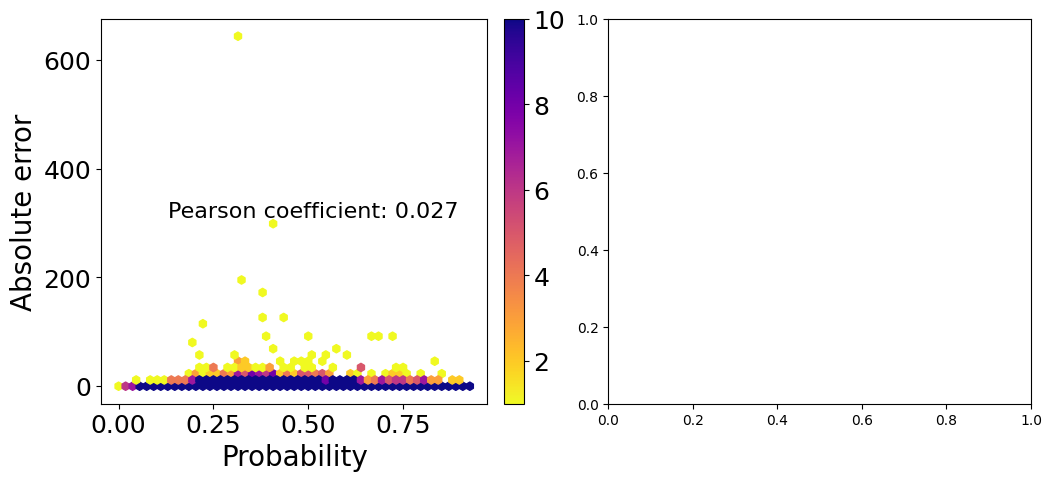

In [9]:
var = 'prob'
name = 'Probability'

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ccc_prob = calc_ccc(all[var], all[var])
co_prob = np.corrcoef(all[var], all['mape'])[0, 1]  
hb1 = axes[0].hexbin(all[var], all['mape'], gridsize=50, cmap='plasma_r', mincnt=1, vmax=10)
axes[0].set_xlabel(name, fontsize=20)
axes[0].set_ylabel('Absolute error', fontsize=20)
# axes[0].set_ylim([0,25])
axes[0].tick_params(labelsize=18)
axes[0].text(0.55, 0.5, f"Pearson coefficient: {co_prob:.3f}", fontsize=16, transform=axes[0].transAxes, ha='center', va='center')
cbar1 = fig.colorbar(hb1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=18)

# ccc_iso = calc_ccc(all['iso_score'], all[var])
co_iso = np.corrcoef(all[var], all['piw'])[0, 1]  
hb2 = axes[1].hexbin(all[var], all['piw'], gridsize=50, cmap='plasma_r', mincnt=1, vmax=20)
axes[1].set_xlabel(name, fontsize=20)
axes[1].set_ylabel('PIW', fontsize=20)
axes[1].tick_params(labelsize=18)
axes[1].text(0.55, 0.8, f"Pearson coefficient: {co_iso:.3f}", fontsize=16, transform=axes[1].transAxes, ha='center', va='center')
cbar2 = fig.colorbar(hb2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=18)  

plt.tight_layout()
plt.show()

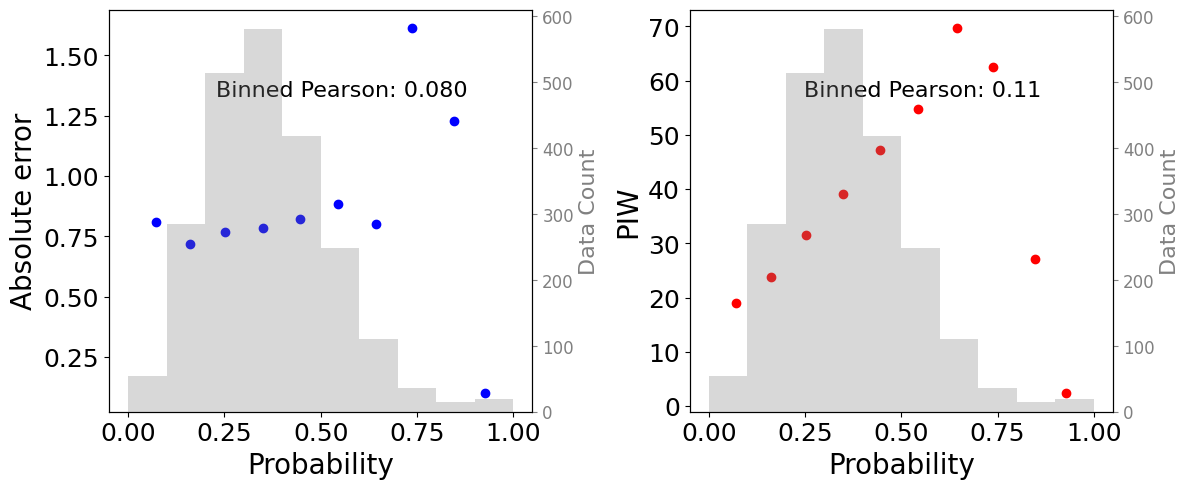

In [20]:

bin_width = 0.1

# Binning data on Probability
prob_bins = np.arange(all['prob'].min(), all['prob'].max() + bin_width, bin_width)
prob_bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2  # Calculate bin centers
prob_means = all.groupby(pd.cut(all['prob'], prob_bins))['prob'].mean()
ae_means_prob = all.groupby(pd.cut(all['prob'], prob_bins))['mape'].mean()
piw_means_prob = all.groupby(pd.cut(all['prob'], prob_bins))['piw'].mean()

valid_prob_mask = ~prob_means.isna() & ~ae_means_prob.isna()
prob_means = prob_means[valid_prob_mask]
ae_means_prob = ae_means_prob[valid_prob_mask]
piw_means_prob = piw_means_prob[valid_prob_mask]

co_ae = np.corrcoef(prob_means, ae_means_prob)[0, 1]
co_piw = np.corrcoef(prob_means, piw_means_prob)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1_bar = ax1.twinx()  

counts_prob = all.groupby(pd.cut(all['prob'], prob_bins))['prob'].count()
ax1_bar.bar(prob_bin_centers, counts_prob, width=bin_width, color='grey', alpha=0.3, label='Data Count')
ax1_bar.set_ylabel('Data Count', fontsize=16, color='grey')
ax1_bar.tick_params(axis='y', labelsize=12, colors='grey')

ax1.scatter(prob_means, ae_means_prob, color='blue', label='Binned Averages')
ax1.set_xlabel('Probability', fontsize=20)
ax1.set_ylabel('Absolute error', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.text(0.55, 0.8, f"Binned Pearson: {co_ae:.3f}", fontsize=16, transform=ax1.transAxes, ha='center', va='center')
# ax1.legend(fontsize=16)

ax2 = axes[1]
ax2_bar = ax2.twinx()  

ax2_bar.bar(prob_bin_centers, counts_prob, width=bin_width, color='grey', alpha=0.3, label='Data Count')
ax2_bar.set_ylabel('Data Count', fontsize=16, color='grey')
ax2_bar.tick_params(axis='y', labelsize=12, colors='grey')

# Scatter plot
ax2.scatter(prob_means, piw_means_prob, color='red', label='Binned Averages')
ax2.set_xlabel('Probability', fontsize=20)
ax2.set_ylabel('PIW', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.text(0.55, 0.8, f"Binned Pearson: {co_piw:.2f}", fontsize=16, transform=ax2.transAxes, ha='center', va='center')
# ax2.legend(fontsize=16)

plt.tight_layout()
plt.show()


In [28]:
piw_means_prob

piw
(0.0, 10.0]         7.113107
(10.0, 20.0]       15.139213
(20.0, 30.0]       24.710786
(30.0, 40.0]       34.913596
(40.0, 50.0]       44.621246
(50.0, 60.0]       54.906430
(60.0, 70.0]       64.228599
(70.0, 80.0]       75.053263
(80.0, 90.0]       84.733498
(90.0, 100.0]      94.190602
(100.0, 110.0]    105.569483
(110.0, 120.0]    114.910950
(120.0, 130.0]    122.986293
(130.0, 140.0]    133.673434
(140.0, 150.0]    144.150026
(150.0, 160.0]    152.047883
(160.0, 170.0]    166.155323
(170.0, 180.0]           NaN
(180.0, 190.0]           NaN
(190.0, 200.0]    194.523768
(200.0, 210.0]           NaN
(210.0, 220.0]           NaN
(220.0, 230.0]           NaN
(230.0, 240.0]    237.974042
(240.0, 250.0]           NaN
(250.0, 260.0]           NaN
(260.0, 270.0]           NaN
(270.0, 280.0]           NaN
(280.0, 290.0]    286.533010
(290.0, 300.0]    295.476819
Name: piw, dtype: float64

# production isolation tree model

In [21]:
all = pd.read_parquet(f'{folder_path}/data/003_data_overlaid.organized.pq')
all[tgt] = np.log1p(all[prop])

isof.n_jobs=90
isof.fit(all[covs], all[tgt])

joblib.dump(isof, f'{folder_path}/data/ocd_isolation.tree.model_production.joblib')

['/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/data/ocd_isolation.tree.model_production.joblib']